\begin{center}
Gabe Morris
\end{center}

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.integrate import odeint

plt.style.use('../maroon_ipynb.mplstyle')

\pagebreak
\tableofcontents
\pagebreak

\begin{center}
\begin{tabular}{ccc}
ME 3613 & Circuits Example & Gabe Morris \\
& & gnm54
\end{tabular}
\end{center}

# Given

![Figure 1](f1.PNG)

$$
\begin{gathered}
L_1=5\,mH,\ L_2=2\,mH \\
C_1=80\,mF,\ C_2=50\,mF \\
R_1=1\,k\Omega,\ R_2=600\,\Omega,\ R_3=300\,\Omega \\
v_1(t)=120\sin(5 t),\ v_2(t)=120\sin(5 t)e^{-10t},\ v_3(t)=120\sin(5 t)e^{-20t}
\end{gathered}
$$

# Find
Solve for the actual currents $i_a$, $i_b$, and $i_c$ by

a. Constructing the ODE's of the system.
b. Put the system in the state-variable form.
c. Solve using `odeint` and plot $i_a(t)$, $i_b(t)$, and $i_c(t)$ up to 2 seconds.

# Solution
## Part A

In [2]:
L1, L2 = sp.symbols('L1 L2')
C1, C2 = sp.symbols('C1 C2')
R1, R2, R3 = sp.symbols('R1 R2 R3')
t = sp.Symbol('t')

L1_, L2_ = 5e-3, 2e-3
C1_, C2_ = 80e-3, 50e-3
R1_, R2_, R3_ = 1_000, 600, 300

sub_values = [
    (L1, L1_),
    (L2, L2_),
    (C1, C1_),
    (C2, C2_),
    (R1, R1_),
    (R2, R2_),
    (R3, R3_)
]

v1_ = 120*sp.sin(5*t)
v2_ = 120*sp.sin(5*t)*sp.exp(-10*t)
v3_ = 120*sp.sin(5*t)*sp.exp(-20*t)

v1_diff = sp.lambdify(t, v1_.diff(), modules='numpy')
v2_diff = sp.lambdify(t, v2_.diff(), modules='numpy')
v3_diff = sp.lambdify(t, v3_.diff(), modules='numpy')

v1, v2, v3 = sp.Function('v1')(t), sp.Function('v2')(t), sp.Function('v3')(t)
i0, i1, i2, i3, i4 = [sp.Function(f'i{i}')(t) for i in range(5)]

eq1 = sp.Eq(L1*i0.diff(t, 2) + 1/C1*(i0 - i1), v1.diff())
eq2 = sp.Eq(R1*i1.diff() + R2*(i1.diff() - i2.diff()) + 1/C1*(i1 - i0), 0)
eq3 = sp.Eq(1/C2*(i2 - i3) + R2*(i2.diff() - i1.diff()), 0)
eq4 = sp.Eq(L2*i3.diff(t, 2) + v2.diff() + 1/C2*(i3 - i2), 0)
eq5 = sp.Eq(v3.diff() + R3*i4.diff(), 0)

eqs = [eq1, eq2, eq3, eq4, eq5]
display(*eqs)

Eq(L1*Derivative(i0(t), (t, 2)) + (i0(t) - i1(t))/C1, Derivative(v1(t), t))

Eq(R1*Derivative(i1(t), t) + R2*(Derivative(i1(t), t) - Derivative(i2(t), t)) + (-i0(t) + i1(t))/C1, 0)

Eq(R2*(-Derivative(i1(t), t) + Derivative(i2(t), t)) + (i2(t) - i3(t))/C2, 0)

Eq(L2*Derivative(i3(t), (t, 2)) + Derivative(v2(t), t) + (-i2(t) + i3(t))/C2, 0)

Eq(R3*Derivative(i4(t), t) + Derivative(v3(t), t), 0)

## Part B

In [3]:
i5, i6 = sp.Function('i5')(t), sp.Function('i6')(t)

eq6 = sp.Eq(i0.diff(), i5)
eq7 = sp.Eq(i3.diff(), i6)

sub_states = [
    (i0.diff(), i5),
    (i3.diff(), i6)
]

eqs_subs = [eq.subs(sub_states) for eq in eqs]
state_sol = sp.solve(eqs_subs + [eq6, eq7],
                     [i0.diff(), i1.diff(), i2.diff(), i3.diff(), i4.diff(), i5.diff(), i6.diff()])

funcs = []
for key, value in state_sol.items():
    display(sp.Eq(key, value))
    funcs.append(sp.lambdify(
        (i0, i1, i2, i3, i4, i5, i6, v1.diff(), v2.diff(), v3.diff()),
        value.subs(sub_values),
        modules='numpy'
    ))

Eq(Derivative(i0(t), t), i5(t))

Eq(Derivative(i1(t), t), -i2(t)/(C2*R1) + i3(t)/(C2*R1) + i0(t)/(C1*R1) - i1(t)/(C1*R1))

Eq(Derivative(i2(t), t), -i2(t)/(C2*R2) + i3(t)/(C2*R2) - i2(t)/(C2*R1) + i3(t)/(C2*R1) + i0(t)/(C1*R1) - i1(t)/(C1*R1))

Eq(Derivative(i3(t), t), i6(t))

Eq(Derivative(i4(t), t), -Derivative(v3(t), t)/R3)

Eq(Derivative(i5(t), t), Derivative(v1(t), t)/L1 - i0(t)/(C1*L1) + i1(t)/(C1*L1))

Eq(Derivative(i6(t), t), -Derivative(v2(t), t)/L2 + i2(t)/(C2*L2) - i3(t)/(C2*L2))

## Part C

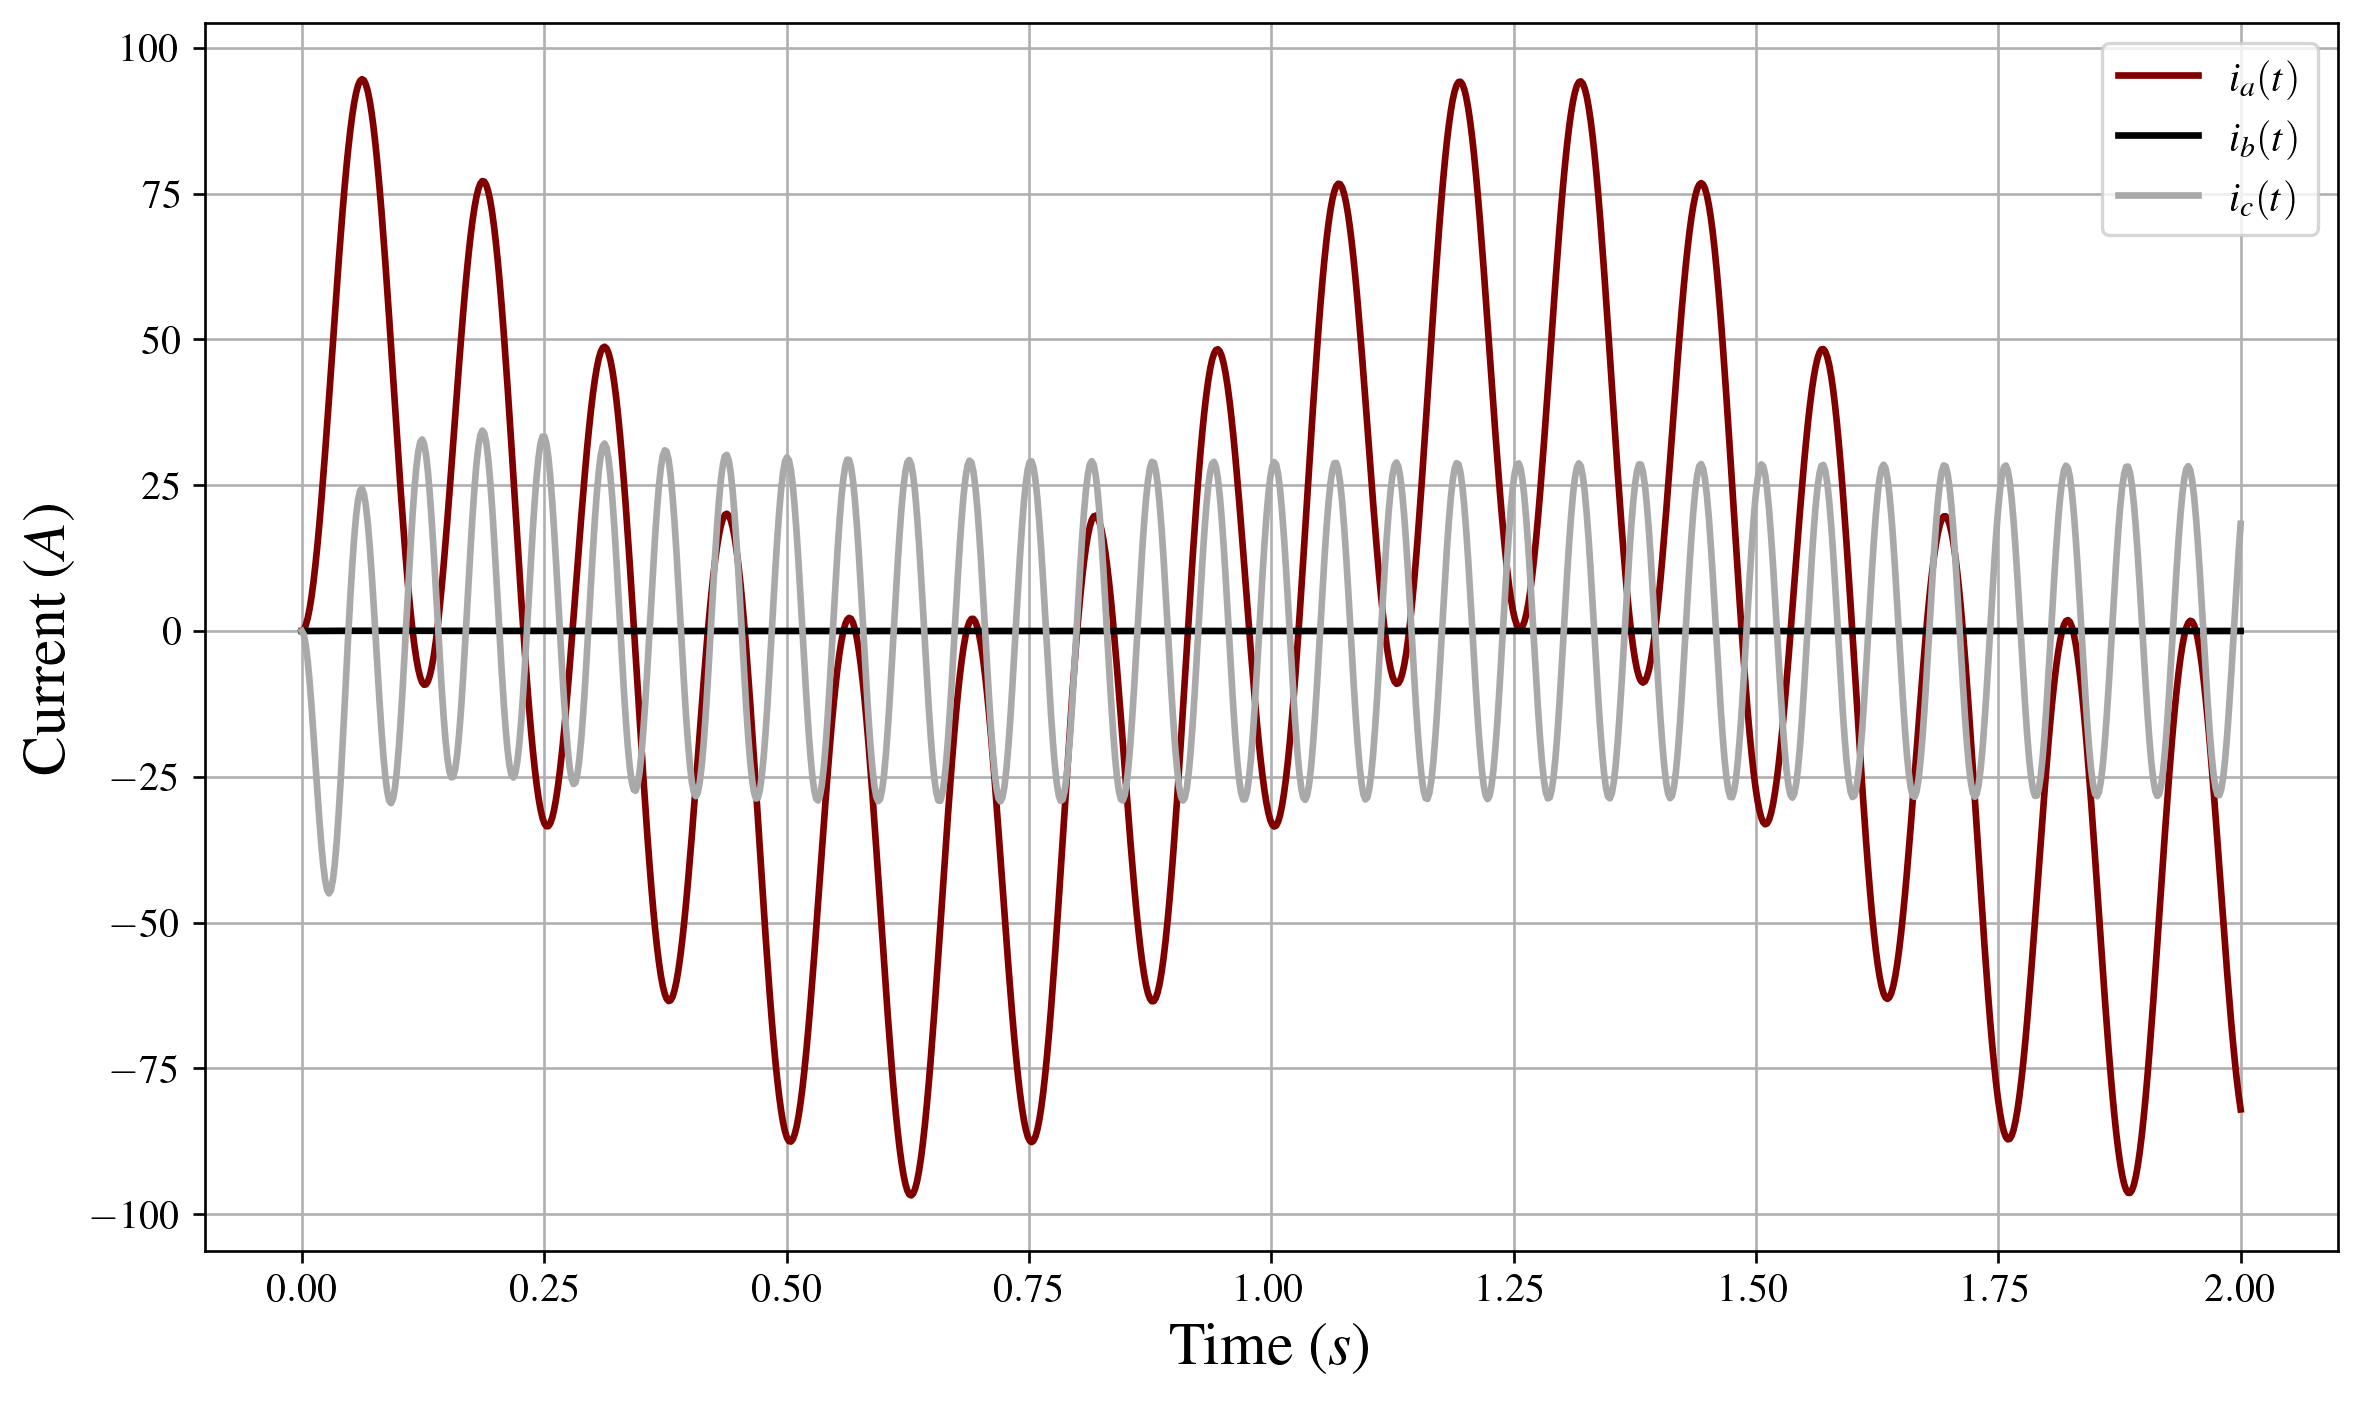

In [4]:
def state_vars(i, t_):
    return [func(i[0], i[1], i[2], i[3], i[4], i[5], i[6], v1_diff(t_), v2_diff(t_), v3_diff(t_)) for func in funcs]


t_array = np.linspace(0, 2, 1000)
sol = odeint(state_vars, (0, 0, 0, 0, 0, 0, 0), t_array)
ia = sol[:, 0]
ib = sol[:, 1] - sol[:, 2]
ic = sol[:, 3] - sol[:, 2]

plt.plot(t_array, ia, label='$i_a(t)$')
plt.plot(t_array, ib, label='$i_b(t)$')
plt.plot(t_array, ic, label='$i_c(t)$')
plt.xlabel('Time ($s$)')
plt.ylabel('Current ($A$)')
plt.legend()
plt.show()